In [1]:
import torch
import numpy as np
import normflows as nf

seed=42
torch.manual_seed(seed)
torch.no_grad()

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.join(c_directory, 'BSCD'))
sys.path.append(os.path.join(c_directory, 'FCYeast'))
sys.path.append(os.path.join(c_directory, 'FCYeast3'))

from matplotlib import pyplot as plt
import FC3_simulator

enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
target = FC3_simulator.target()
context_size = 6

latent_size = 1
hidden_units = 128
hidden_layers = 5

/home/pessoa/Codes/SBI-posterior/FCYeast3/FC3_simulator.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBI-posterior/FCYeast3/FC3_simulator.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [14]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 512,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]
    model_file = c_directory+'/FCYeast3/dilution{}/FCYeast_network.pt'.format(dil)
    q0 = nf.distributions.DiagGaussian(1)
    model = nf.ConditionalNormalizingFlow(q0, flows, target)
    model = model.to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.load_state_dict(torch.load(model_file))
    models.append(model)

In [15]:
import pandas as pd

dils = [.12,.23,.33]

dfs = [pd.read_csv('clean_data/complete_d={}.csv'.format(d)) for d in dils]
x = [torch.tensor(df['FL1-A'].to_numpy().astype(np.float32)).reshape(-1,1).to(device) for df in dfs]

ind = torch.arange(0,x[0].size(0),10)
x = [torch.log(xi[ind]) for xi in x]

In [16]:
def separate(x):
    return torch.tensor(((x[0],x[1],x[2],x[3],x[4],x[11]),
                         (x[0],x[1],x[5],x[6],x[7],x[11]),
                         (x[0],x[1],x[8],x[9],x[10],x[11]))).to(device)

to_hours = -torch.tensor(((0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0),
                         (0,0,-1,-1,1,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_hour(x): #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all in hours
    return separate(x) + to_hours


to_arbitrary = -torch.tensor(((1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0),
                             (1,1, 0, 0,0,0)),device=device)*torch.log(torch.tensor(dils)).reshape(-1,1).to(device)

def transform_to_arbitrary(x):  #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all to arbitrary
    return separate(x) + to_arbitrary
    

In [17]:
def logprior(params):
    return target.prior.log_prob(params)

vectorize_params = [torch.ones(xi.size(0),6).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),6),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,transform_to_arbitrary(params),models)]) + lprior(params)

In [18]:
params_100 = target.prior.sample((1000,))
params_100[:,0] -=1.
best_param = params_100[0]
lp_max = log_post(x,best_param,models)

for par in params_100[1:]:
    lp_par = log_post(x,par,models)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par
        print(best_param,lp_max)

for i in range(3,10):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 3.6740,  6.8400,  2.3551, -0.6924, -2.2541, -1.1835, -1.8029, -2.6952,
         0.8387,  1.4192, -2.1383,  0.8505], device='cuda:0') tensor(-228293.5000, device='cuda:0')
tensor([ 3.6653,  7.4742, -0.8776,  0.3938, -2.2590, -0.1977,  1.0104, -2.6371,
        -0.3498, -0.6443, -2.1883, -1.0742], device='cuda:0') tensor(-85915.2188, device='cuda:0')
tensor([ 2.9268,  7.9767, -0.3657, -0.4866, -2.2626, -1.5095,  0.3103, -2.4122,
        -1.0967, -1.2699, -2.6944, -3.1771], device='cuda:0') tensor(-68847.0469, device='cuda:0')
tensor([ 3.3439,  8.7600, -0.6073,  0.3023, -2.6360, -0.3185,  0.5932, -2.1569,
        -0.7558, -0.1266, -2.4080, -2.7887], device='cuda:0') tensor(-63848.7188, device='cuda:0')
tensor([ 4.2984,  7.0430,  0.9844,  0.3784, -2.0150, -0.2939,  0.0926, -1.7873,
        -0.2688,  0.9666, -2.6035, -2.2129], device='cuda:0') tensor(-62249.5547, device='cuda:0')


KeyboardInterrupt: 

In [ ]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [ ]:
S = torch.eye(12)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(12,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [ ]:
proposal(best_param)

tensor([ 4.0052,  7.7048, -0.6041, -0.0690, -2.3989, -1.6949,  0.1165, -2.2382,
        -1.6667,  1.0537, -2.3549, -2.0527], device='cuda:0')

In [ ]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(12)*1e-8) * (2.4**2/(12)) )
    loopruns+=1

    print(loopruns,acc_rate, '    ', sampled_logpost[-1])
    



1 0.45      -42489.08984375


2 0.44      -41975.62890625
3 0.3      -41676.7265625
4 0.25      -41356.33203125
5 0.18      -41283.7421875
6 0.08      -41260.74609375
7 0.41      -41173.828125
8 0.39      -41089.6796875
9 0.35      -41041.69140625
10 0.33      -40941.1796875
11 0.16      -40928.68359375
12 0.2      -40912.21875
13 0.47      -40887.51171875
14 0.47      -40879.3828125
15 0.5      -40870.20703125
16 0.43      -40845.91796875
17 0.31      -40845.265625
18 0.52      -40843.04296875
19 0.39      -40831.34765625
20 0.24      -40831.7109375
21 0.1      -40827.40234375
22 0.41      -40828.61328125
23 0.52      -40826.953125
24 0.47      -40831.9921875
25 0.37      -40826.15625
26 0.48      -40824.1171875
27 0.34      -40823.1484375
28 0.55      -40819.48046875
29 0.43      -40823.921875
30 0.38      -40823.61328125
31 0.38      -40821.76171875
32 0.46      -40827.4375
33 0.41      -40820.875
34 0.47      -40822.828125
35 0.38      -40821.2578125
36 0.4      -40821.7578125
37 0.47      -40823.30859375
38 0.

In [ ]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 2.7378,  8.1183, -0.3104,  2.9148, -2.0411, -1.9989,  1.8392, -0.6493,
        -3.3384,  2.4882, -1.1211, -0.5924], device='cuda:0') tensor(-40823.7148, device='cuda:0')
199 tensor([ 2.7622,  8.1244, -0.3192,  2.9293, -2.0350, -1.9702,  1.8697, -0.6723,
        -3.3529,  2.5271, -1.0892, -0.6028], device='cuda:0') tensor(-40826.6094, device='cuda:0')
299 tensor([ 2.7686,  8.0643, -0.3272,  2.8468, -2.0431, -1.9994,  1.7809, -0.6553,
        -3.3235,  2.5203, -1.1744, -0.5996], device='cuda:0') tensor(-40824., device='cuda:0')
399 tensor([ 2.7718,  8.1250, -0.3211,  2.8509, -2.1285, -2.0028,  1.8101, -0.6675,
        -3.3061,  2.5635, -1.1540, -0.6276], device='cuda:0') tensor(-40820.4922, device='cuda:0')
499 tensor([ 2.7362,  8.0514, -0.3311,  2.8413, -2.1626, -1.9893,  1.7971, -0.7069,
        -3.3110,  2.5298, -1.0605, -0.5649], device='cuda:0') tensor(-40822.0430, device='cuda:0')
599 tensor([ 2.7221,  8.2046, -0.2967,  3.0189, -2.1300, -1.9900,  1.9571, -0.6576,
      

KeyboardInterrupt: 

In [ ]:
np.savetxt('mcmc_real_results_{}seed.csv'.format(seed),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

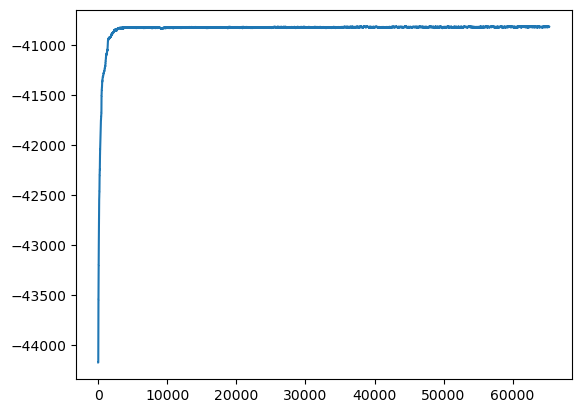

In [ ]:
plt.plot(sampled_logpost)

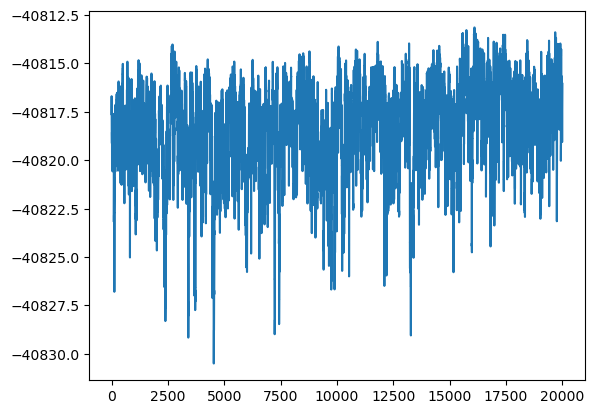

In [ ]:
plt.plot(sampled_logpost[-20000:])

In [ ]:

def grid_plot(x,param,model):
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,6),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    return xp.cpu(),p.cpu()




TypeError: randn() received an invalid combination of arguments - got (tuple, device=torch.device, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


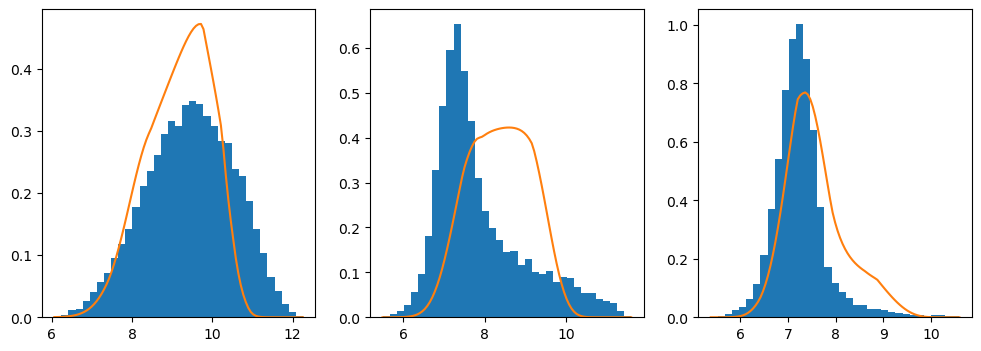

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]
params = transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]
x

plt.legend()